In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import sem, t
from scipy import mean
from sklearn.feature_selection import mutual_info_regression

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import pickle 

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from trial_config import read_config
from statistics_tests import perform_ks, estimate_power_with_data
from status import Status

In [2]:
config_file = "../config.ini"

In [3]:
config = read_config(config_file)
config_file = "../config.ini"
trial = config["name"]
directory_path = config["score_dir"]
print(f"Trial: {trial} from {directory_path}") 

Trial: LLM_Compare_Score from ./data/scoring


# Score Component Tests

In [4]:
columns = ['Embedding Anomaly Time (ms)', 'Resource Anomaly Time (ms)', 'Resource Scaled Time (ms)', 'Total Time (ms)']
df = pd.DataFrame(columns=columns)

files = [f for f in os.listdir(directory_path) 
         if f.endswith('.pkl')]

In [5]:
for f in files:
    # Regular expression pattern to capture the required parts
    pattern = r"LLM_Compare_(.+?)___(.+?)\.pkl"

    # Use re.match to apply the pattern
    match = re.match(pattern, f)
    assert match, f"Bad filename {f}"
    trial_name = match.group(1)
    func_name = match.group(2)
    if trial_name != "Score": continue # Skip all others, since score contains samples for all
    #print(trial_name, func_name)
    with open(f"{directory_path}/{f}", 'rb') as file: d = pickle.load(file)
    data = d["Performance"]
    
    df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)


/tmp/ipykernel_233622/1392490840.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)


In [7]:
# Oversight correction, did not retain the number of samples
# All sizes between 110,000 and 111,000 -- estimating at 110k since the addition of up to 1k samples is negligible
df = 0.91 * df # Scale down to 100k sample times

/tmp/ipykernel_233622/2814885659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Time (ms)', data=df_melted[df_melted['Metric'] == metric], palette=[color])
/tmp/ipykernel_233622/2814885659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Time (ms)', data=df_melted[df_melted['Metric'] == metric], palette=[color])
/tmp/ipykernel_233622/2814885659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Time (ms)', data=df_melted[df_melted['Metric'] == metric], palette=[color])
/tmp/ip

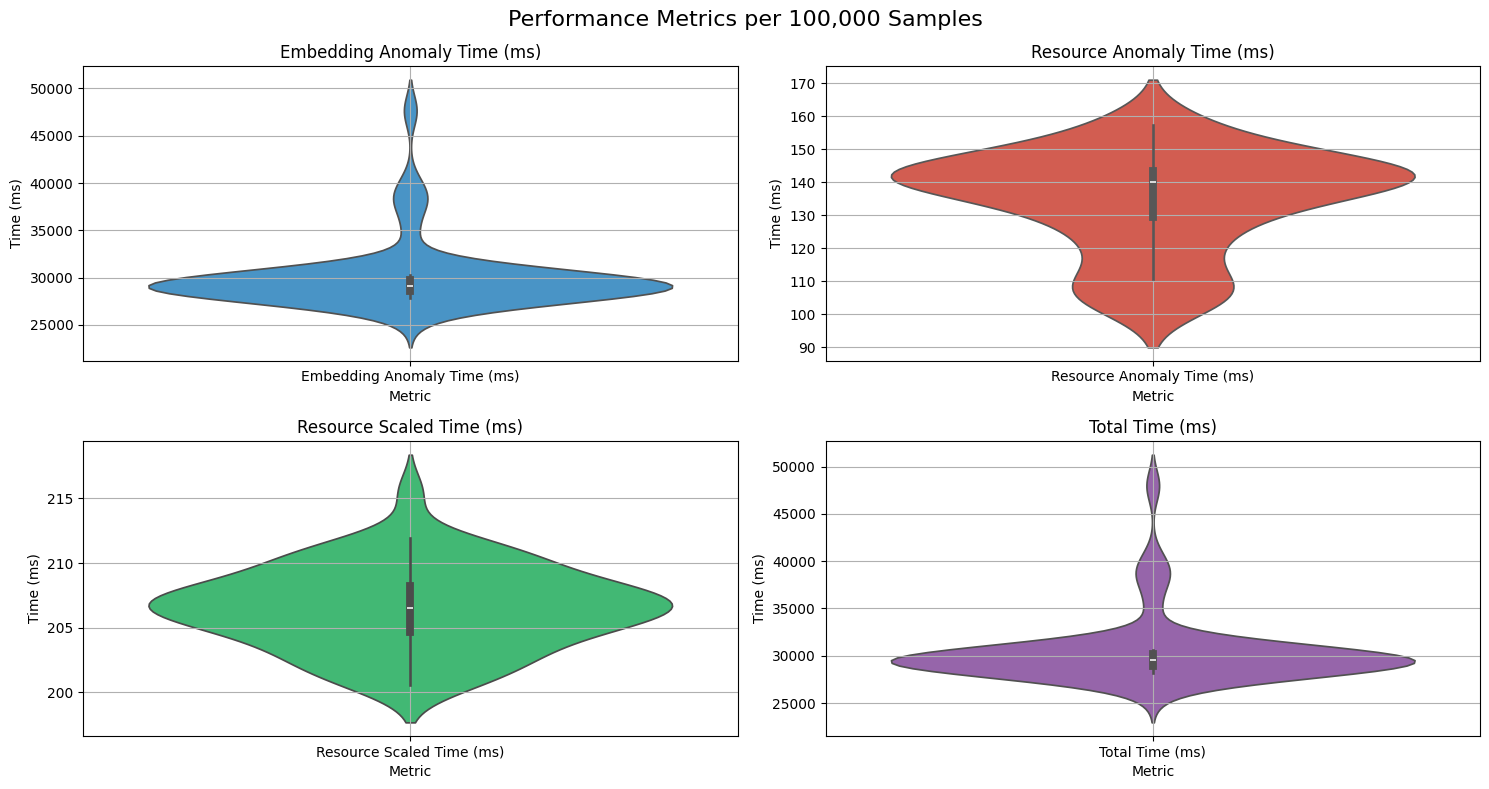

In [13]:
df_melted = df.melt(var_name='Metric', value_name='Time (ms)')

metrics = df_melted['Metric'].unique()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

plt.figure(figsize=(15, 8))

for i, (metric, color) in enumerate(zip(metrics, colors), 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x='Metric', y='Time (ms)', data=df_melted[df_melted['Metric'] == metric], palette=[color])
    plt.title(metric)
    plt.grid(True)

plt.suptitle("Performance Metrics per 100,000 Samples", fontsize=16)
plt.tight_layout()
plt.savefig(f'../images/performance_scoring.png', bbox_inches='tight')
plt.show()


# Resource Collection Times

In [7]:
directory_path = config["directory"]
print(directory_path)
# Get all files that end with .parquet
files = [f for f in os.listdir(directory_path) 
         if f.endswith('.parquet') ]
rows = []
all_df = pd.DataFrame()
for filename in tqdm(files, desc="Processing files"):
    name_without_extension = os.path.splitext(filename)[0]

    file_path = os.path.join(directory_path, filename)
    #print(file_path)
    df = pd.read_parquet(file_path)
    df['Name'] = name_without_extension
    all_df = pd.concat([all_df, df], ignore_index=True)


./data/resource_results


Processing files: 100%|███████████████████████████████████████████████████████████████| 350/350 [00:33<00:00, 10.39it/s]


In [8]:
# Used to ensure that other graphs have the same function names in the same order
with open("./data/function_names.pkl", 'rb') as file:
    fnames = pickle.load(file)
    
# Function to clean fnames (remove "...")
def clean_name(name):
    return name.replace("...", "")

# Create a new column to store the order based on fnames
all_df['Order'] = -1  # Initialize with -1 for non-matches

# Assign order based on the appearance in fnames
for order, fname in enumerate(tqdm(fnames, desc="Processing function names")):
    cleaned_fname = clean_name(fname)
    all_df.loc[all_df['Name'].str.contains(cleaned_fname, regex=False), 'Function'] = fname
    all_df.loc[all_df['Name'].str.contains(cleaned_fname, regex=False), 'Order'] = order

# Sort the DataFrame based on the 'Order' column
all_df_sorted = all_df.sort_values(by='Order')

# Drop the 'Order' column if not needed anymore
all_df_sorted = all_df_sorted.drop(columns=['Order'])

# Display the sorted DataFrame
all_df_sorted

,Function,Corpus,Sample,Error,Output,Output Size (B),Output Entropy (bits per symbol),Function Calls,Top Function,Top Function Calls,Peak Memory (B),Final Memory (B),CPU (ms),Repetitions,SLOC,Instructions,Duration (ms),Name
4087575,yaml_safe_load,./corpora/yaml.safe_load/atheris_output,69360.txt,unacceptable character #x0084: invalid start b...,,0,0.000000,21,builtins.isinstance},3,4625,0,0.081519,10,59,63,0.704050,yaml_safe_load_Atheris
4087576,yaml_safe_load,./corpora/yaml.safe_load/atheris_output,69361.txt,unacceptable character #x0084: invalid start b...,,0,0.000000,21,builtins.isinstance},3,4625,0,0.081185,10,59,63,0.707150,yaml_safe_load_Atheris
4087577,yaml_safe_load,./corpora/yaml.safe_load/atheris_output,69362.txt,while parsing a flow node\nexpected the node c...,,0,0.000000,181,builtins.isinstance},24,4539,224,0.384312,10,384,787,3.176451,yaml_safe_load_Atheris
4087578,yaml_safe_load,./corpora/yaml.safe_load/atheris_output,69363.txt,,None\n,5,2.321928,93,builtins.isinstance},10,4539,112,0.203388,10,251,361,1.934052,yaml_safe_load_Atheris
4087579,yaml_safe_load,./corpora/yaml.safe_load/atheris_output,69364.txt,,None\n,5,2.321928,93,builtins.isinstance},10,4539,112,0.202350,10,251,361,1.921892,yaml_safe_load_Atheris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4118333,cgi_parse_multipart_pdict,./corpora/cgi.parse_multipart_pdict/random_data,84.txt,'ascii' codec can't decode byte 0xf4 in positi...,,0,0.000000,22,builtins.ord},9,4578,59,0.094955,10,20,30,0.678062,cgi_parse_multipart_pdict_Random
4118309,cgi_parse_multipart_pdict,./corpora/cgi.parse_multipart_pdict/random_data,60.txt,'ascii' codec can't decode byte 0xf4 in positi...,,0,0.000000,23,builtins.ord},10,4954,59,0.101658,10,20,31,0.739813,cgi_parse_multipart_pdict_Random
4118338,cgi_parse_multipart_pdict,./corpora/cgi.parse_multipart_pdict/random_data,89.txt,'ascii' codec can't decode byte 0xf4 in positi...,,0,0.000000,23,builtins.ord},10,5009,59,0.097304,10,20,31,0.678539,cgi_parse_multipart_pdict_Random
4118376,cgi_parse_multipart_pdict,./corpora/cgi.parse_multipart_pdict/random_data,127.txt,Invalid boundary in multipart form: b'\x7f\x02...,,0,0.000000,116,objects},24,4910,59,0.283724,10,169,250,1.908302,cgi_parse_multipart_pdict_Random


/tmp/ipykernel_234141/3877577446.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_234141/3877577446.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


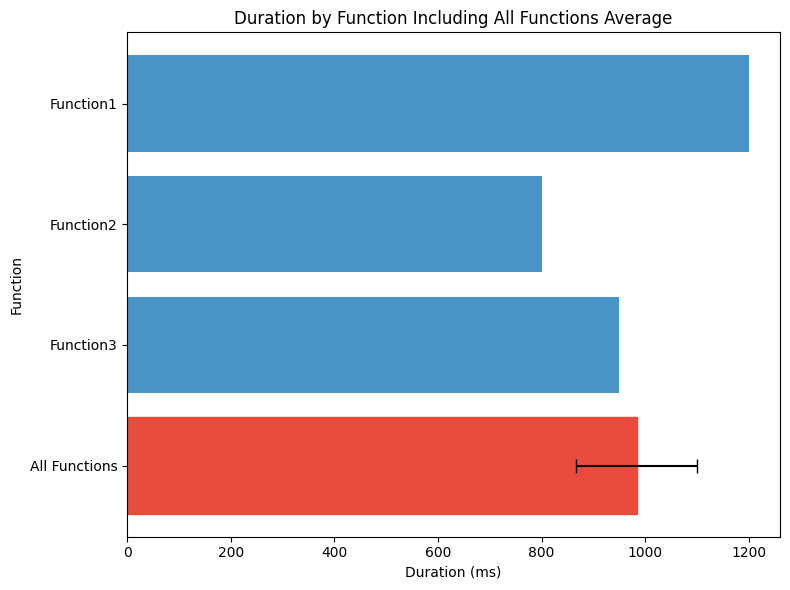

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Calculate the mean and standard error for "All Functions"
mean_duration = all_df['Duration (ms)'].mean()
stderr_duration = all_df['Duration (ms)'].sem()

# Create a new DataFrame for the "All Functions" row
all_functions_df = pd.DataFrame({
    'Function': ["All Functions"],
    'Duration (ms)': [mean_duration]
})

# Concatenate the original DataFrame with the new row
all_df = pd.concat([all_df, all_functions_df], ignore_index=True)

# Plotting
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=all_df, 
    x='Duration (ms)', 
    y='Function', 
    ci=None,  # Disable internal confidence interval calculation
    palette=["#3498db"] * len(all_df)  # Set initial color palette
)

# Highlight the "All Functions" bar
all_functions_index = all_df[all_df['Function'] == 'All Functions'].index[0]
ax.patches[all_functions_index].set_color("#e74c3c")  # Set a different color for distinction

# Add error bar for "All Functions"
plt.errorbar(
    x=mean_duration, 
    y=all_functions_index, 
    xerr=stderr_duration, 
    fmt='none', 
    c='black', 
    capsize=5
)

# Improve layout
plt.title('Duration by Function Including All Functions Average')
plt.xlabel('Duration (ms)')
plt.ylabel('Function')
plt.tight_layout()

# Show plot
plt.show()
